In [74]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
import json
import re
import scipy.stats as st

In [5]:
from ECMpy_function import *

In [6]:
cobra.__version__

'0.26.2'

# Create sMOMENT model from ECMpy style ec-model

In [43]:
def convert_ECMpy_to_sMOMENT(json_model_file, output_filename):
    """using enzyme concentration constraint
    json model to create a COBRApy model in sMOMENT style.
    Modified from get_enzyme_constraint_model in ECMpy

    Arguments
    ----------
    * json_model_file: json Model file.
    * output_filename: Path to sMOMENT sbml file

    :return: Enzyme-constrained model in sMOMENT style.
    """

    dictionary_model = json_load(json_model_file)
    model = cobra.io.json.load_json_model(json_model_file)

    prot_pool = cobra.Metabolite(id = "prot_pool", name = "Pseudo-metabolite representing the preotein pool", 
                                 compartment = "c", charge = 0)
    for rxn in model.reactions:
        for eachr in dictionary_model['reactions']:
            if rxn.id == eachr['id']:
                if eachr['kcat_MW']:
                    coefficient = -1/float(eachr['kcat_MW'])
                    rxn.add_metabolites({prot_pool: coefficient})
                break
    # Add pool reaction
    lowerbound = dictionary_model['enzyme_constraint']['lowerbound']
    upperbound = dictionary_model['enzyme_constraint']['upperbound']
    prot_exchange = cobra.Reaction(id = "prot_pool_reaction", name = "prot_pool reaction for unmeasured proteins",
                                   lower_bound  = lowerbound, upper_bound=upperbound)
    prot_exchange.add_metabolites({prot_pool:1})
    model.add_reactions([prot_exchange])
    
    model.solver.update()
    model.id = "ecCGL1_sMOMENT_style"
    cobra.io.write_sbml_model(model, output_filename)
    return model

In [44]:
ecmodel_fn = 'models/c_glutamicum/smoment_iCW773.xml'
ecmodel = convert_ECMpy_to_sMOMENT('models/c_glutamicum/ecCGL1/iCW773_irr_enz_constraint_adj_PDH.json', ecmodel_fn)

In [ ]:
solution = ecmodel.optimize()
ecmodel.summary()

In [39]:
ecmodel.reactions.EX_glc_e_reverse.bounds = (0, 5.05)

In [ ]:
ecmodel.optimize()
print(ecmodel.summary())

## Load and run model in ECMpy to verify that results are identical

In [ ]:
ecModel_final_output_file = 'models/c_glutamicum/ecCGL1/iCW773_irr_enz_constraint_adj_PDH.json'
obj='CG_biomass_cgl_ATCC13032'
use_substrate='EX_glc_e'
enz_model=get_enzyme_constraint_model(ecModel_final_output_file)

enz_model.objective=obj
#Using only the provided substrate
[ori_obj_id,ori_substrate_id_list,ori_sub_concentration,ori_ATPM]=get_model_substrate_obj(enz_model)
for eachsubid in ori_substrate_id_list:
    if re.search('_reverse',eachsubid):
        r_id_new=eachsubid.split('_reverse')[0]
        enz_model.reactions.get_by_id(eachsubid).bounds = (0, 0) 
        enz_model.reactions.get_by_id(r_id_new).bounds = (0, 0)  
    else:
        r_id_new=eachsubid+'_reverse'
        enz_model.reactions.get_by_id(eachsubid).bounds = (0, 0) 
        enz_model.reactions.get_by_id(r_id_new).bounds = (0, 0) 
        
enz_model.reactions.get_by_id(use_substrate).bounds = (-5.05, 0)
enz_model.reactions.get_by_id(use_substrate+'_reverse').bounds = (0, 0)

enz_model_pfba_solution = cobra.flux_analysis.pfba(enz_model)
enz_model_pfba_solution = get_fluxes_detail_in_model(enz_model,enz_model_pfba_solution,fluxes_final_outfile,ecModel_final_output_file)
print(enz_model_pfba_solution.fluxes[obj])

In [ ]:
enz_model.optimize()
enz_model.summary()

# Analyses

In [45]:
# Load sMOMENT model
model = cobra.io.read_sbml_model('models/c_glutamicum/smoment_iCW773.xml')

In [ ]:
for r in model.exchanges:
    print(r, r.bounds)

# Check shadow prices

In [85]:
# Set glucose uptake
glucose_uptake = 4
model.reactions.EX_glc_e_reverse.bounds = (0, glucose_uptake)

In [86]:
solution = model.optimize()


In [87]:
# Read measurements
measurements = pd.read_csv('c_glutamicum_measurements.csv')
#measurements.drop(columns = ["Note"], inplace = True)
# Read metabolite mapping
mapping_df = pd.read_csv('id_mapping.csv')

In [88]:
met_id_key = "Metabolite id"
name_to_met_id = mapping_df.loc[:, ["Metabolite name", met_id_key]].set_index("Metabolite name").to_dict()[met_id_key]

In [89]:
solution = model.optimize()
shadow_prices = []
for i, row in measurements.iterrows():
    key = name_to_met_id[row["Metabolite"]]
    try:
        keys = key.split(",")
    except:
        print(key)
        shadow_prices.append(np.nan)
        continue
    values = []
    for key in keys:
        met_id = "{0}_c".format(key.strip())
        try:
            values.append(solution.shadow_prices[met_id])
        except KeyError:
            pass
    shadow_prices.append(max(values))

nan
nan
nan


In [102]:
df = measurements.copy()
df["Shadow price"] = np.abs(shadow_prices)
df = df.loc[~df.isna().any(axis = 1), :]
df = df.loc[df.Value != 0, :]
df = df.loc[df["Shadow price"] != 0, :]
#df = df.loc[df["Metabolite"] != "Methionine"]
df = df.loc[df["Metabolite"] != "Lysine"]

In [96]:
df

,Metabolite,Value,Uncertainty,Shadow price
0,Glucose-6-phosphate,10.16,0.74,0.097845
1,Fructose-6-phosphate,3.84,0.22,0.097845
2,"Fructose-1,6-bisphosphate",3.36,0.07,0.102689
3,Dihydroxyacetonephosphate,8.67,0.10,0.051344
4,Glyceraldehyde-3-phosphate,0.56,0.01,0.051344
5,2/3-phosphoglycerate,12.17,1.07,0.041657
9,Ribose-5-phosphate,0.61,0.03,0.082345
10,Ribu-/Xylulose-5-phosphate,0.58,0.05,0.082345
11,Erythrose-4-phosphate,2.47,1.14,0.066844
26,Alanine,64.80,4.21,0.044563


In [103]:
corrp = st.spearmanr(np.log10(df["Value"]), np.log10(df["Shadow price"]))
print(corrp[0], corrp[1])

-0.007524456607127134 0.9748836160869537


In [104]:
corrp = st.pearsonr(np.log10(df["Value"]), np.log10(df["Shadow price"]))
print(corrp[0], corrp[1])

-0.014767511638061035 0.9507277562134541


In [105]:
df["log10(shadow price)"] = np.log10(df["Shadow price"])
df["log10(metabolite concentration)"] = np.log10(df.Value)

Text(-2, -1.55, 'Pearson corr: -0.01, p-value: 0.951')

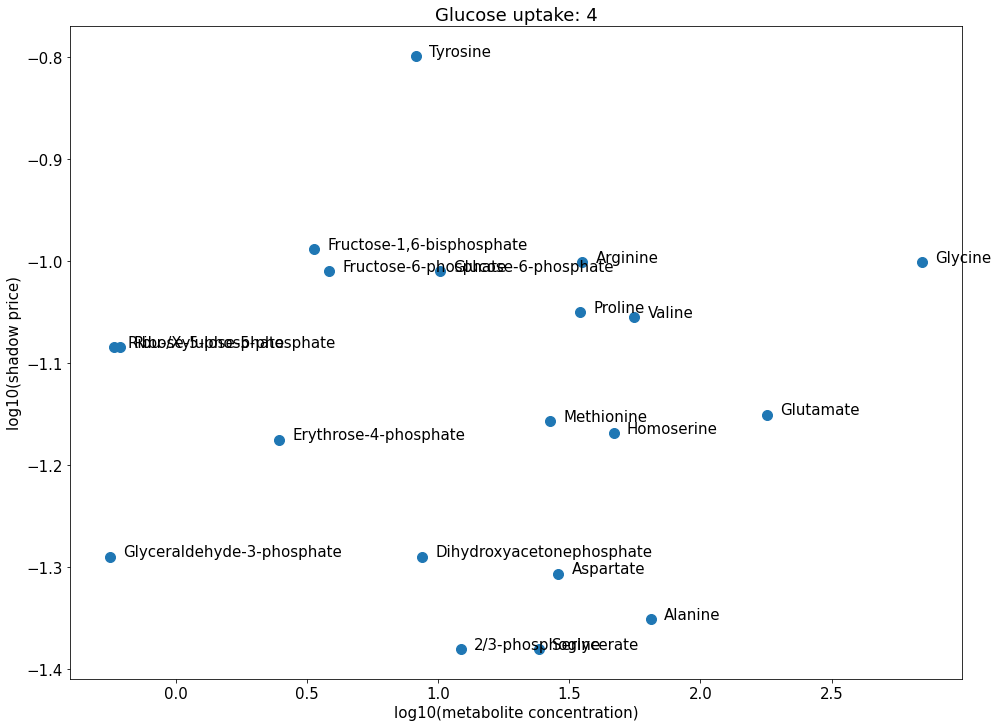

In [106]:
plt.rcParams.update({'font.size': 15})
ax = df.plot.scatter(x = "log10(metabolite concentration)", y = "log10(shadow price)", figsize = (16, 12),
                    fontsize = 15, s = 100)
# Annotate each data point
for i, txt in enumerate(df["Metabolite"]):
    ax.annotate(txt, (df["log10(metabolite concentration)"].iat[i]+0.05, df["log10(shadow price)"].iat[i]))

plt.title("Glucose uptake: {0}".format(glucose_uptake))
#ax.plot(df["log10(metabolite concentration)"], trendline_fun(df["log10(metabolite concentration)"]))
ax.annotate("Pearson corr: {0:.2f}, p-value: {1:.3f}".format(corrp[0], corrp[1]), (-2, -1.55), fontsize = 15, c = 'r')
#ax.annotate("Pearson corr: {0:.2f}, p-value: {1:.3f}".format(corrp[0], corrp[1]), (-1.5, -2.5), fontsize = 15, c = 'r')
#plt.savefig('results/yeast/shadow_price_vs_met_conc_glc{0}.svg'.format(glucose_uptake))
#plt.savefig('results/yeast/shadow_price_vs_met_conc_glc{0}.png'.format(glucose_uptake))